In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import io
from google.colab import drive, files
import torch as torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import Linear
from PIL import Image
import numpy as np
from glob import glob
import scipy as scipy

In [2]:
from google.colab import drive, files
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [3]:
#chemin pour le drive de Marien -> à changer pour Emeric
!cd /content/drive/MyDrive/Colab_Notebooks/Projet_Remote_Sensing

In [4]:
def affiche(im, name):
  choices = {'marais1':190.92, 'marais2': 168.49, 'saclay':470.92, 'lely':235.90, 'ramb':167.22, 'risoul':306.94, 'limagne':178.43}
  threshold = 0
  for x in choices:
    if name == x:
        threshold = choices.get(x)
  if threshold ==0:
    threshold= np.mean(im)+3*np.std(im) 

  dim = np.clip(im,0,threshold)
  dim = dim/threshold*255
  dim = Image.fromarray(dim.astype('float64')).convert('L')
  plt.figure(figsize=(20,10))
  plt.imshow(dim)
  plt.show()

In [ ]:
i = 10
print(('/content/drive/MyDrive/Colab_Notebooks/Projet_Remote_Sensing/PRAT/data/Training/marais1_'+str(i)+'.npy')[80:-7])

marais1


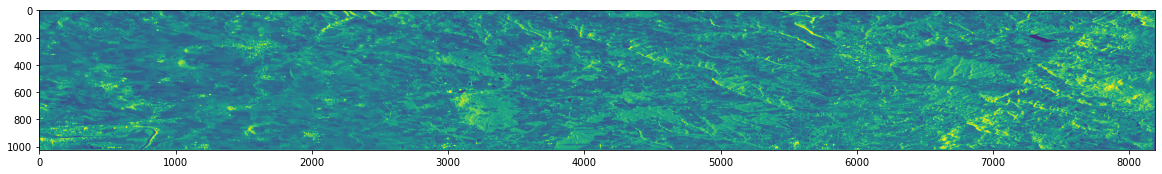

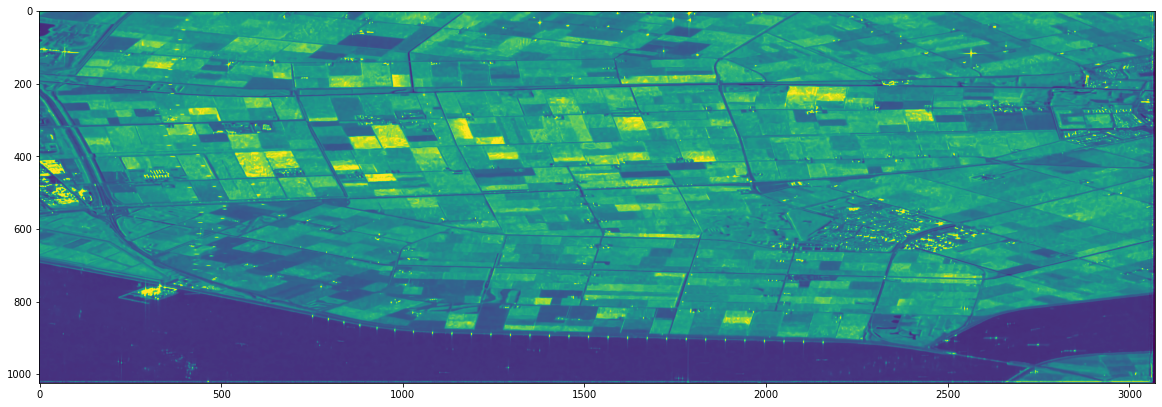

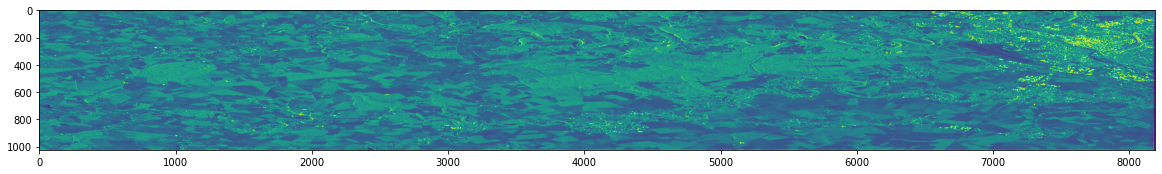

In [ ]:
#calcul des images de ratio et affichage de la moyenne
dic_im = {'marais1', 'lely', 'limagne'}
super_resolution_list = []
Im_ratio_list = []
for short_name in dic_im:
  Im_ratio = []
  affichage_bool = False
  for i in range(10,21):
    name = '/content/drive/MyDrive/Colab_Notebooks/Projet_Remote_Sensing/PRAT/data/Training/'+short_name+'_'+str(i)+'.npy'
    im = np.load(name)
    if affichage_bool:
      affiche(im, short_name)
    Im_ratio.append(im)
  Im_ratio = np.array(Im_ratio)
  super_resolution = np.mean(Im_ratio, axis = 0)
  affiche(super_resolution, short_name)
  super_resolution_list.append(super_resolution)
  Im_ratio = Im_ratio / super_resolution[None,:,:]
  Im_ratio_list.append(Im_ratio)

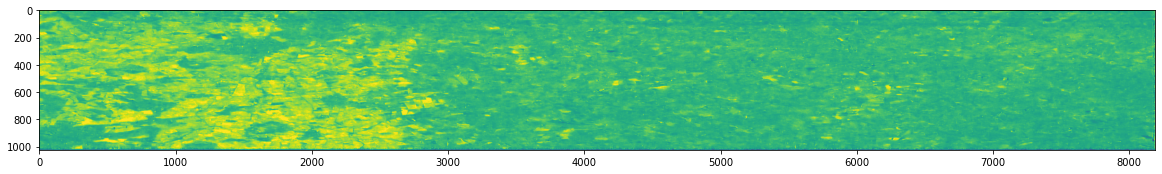

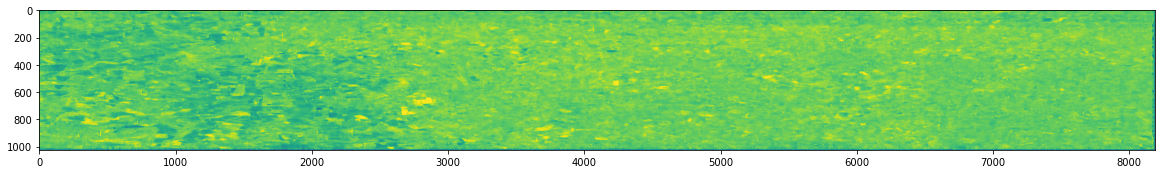

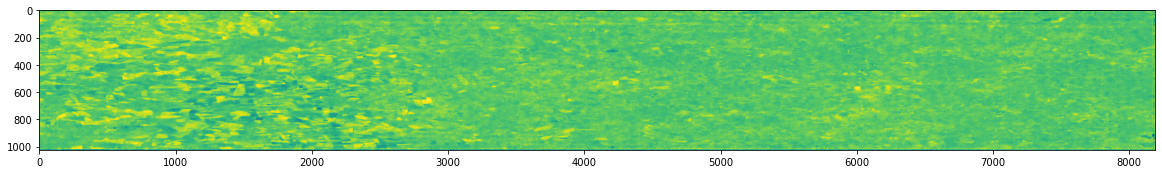

In [ ]:
#Affichage des trois premières images de ratio pour le marais
affiche(Im_ratio_list[0][0], 'random')
affiche(Im_ratio_list[0][1], 'random')
affiche(Im_ratio_list[0][2], 'random')

In [ ]:
#sauvegarder les images de ratio
c = 0
for short_name in dic_im:
  Im_ratio = []
  for i in range(11):
    name = '/content/drive/MyDrive/Colab_Notebooks/Projet_Remote_Sensing/Training_ratio/'+short_name+'_'+str(10+i)+'_ratio'
    np.save(name, Im_ratio_list[c][i])
  c += 1

In [ ]:
#sauvegarde les images super-résolues
c = 0
for short_name in dic_im:
  name = '/content/drive/MyDrive/Colab_Notebooks/Projet_Remote_Sensing/Superresolution_data/'+short_name+'_surperimage'
  np.save(name, super_resolution_list[c])
  c += 1

# Réflexion sur le bruit d'une image de ratio
Le bruit d'une image SAR est un bruit multiplicatif gaussien. Si on prend un ensemble de prise de vue d'un scène $X_i$ pour $i \in [1,n]$ (typiquement ici les $11$ prise de vue des trois scènes que l'on étudie).
On a :
$$ X_i = R_i A_i $$
où $R_i \sim \Gamma(1, L)$ où $L$ est le nombre de vue. Et $A_i$ est l'image déterministe sans bruit.
Alors notre image de ratio est :
$$ \frac{X_i}{\frac{1}{n} \sum_{j=1}^n{X_j}} = \frac{R_i A_i}{\frac{1}{n} \sum_{j=1}^n{R_j A_j}} = \frac{R_i \frac{1}{n} \sum_{j=1}^n{A_j}}{\frac{1}{n} \sum_{j=1}^n{R_j A_j}} \frac{A_i}{\frac{1}{n} \sum_{j=1}^n{A_j}}$$
Le second terme est l'image de ratio déterministe et le premier un bruit multiplicatif qui ne suit clairement pas une loi Gamma. Or ce terme est difficilement exprimable et dépend de $A_i$ qui n'est pas une grandeur connue (on mesure les $X_i$).

On fait donc une hypothèse simplificatrice. Si on est dans un cas où il n'y a pas d'évolution entre les différentes images, c'est à dire $A_i = A,  \forall i \in [1,n]$. On a alors :
$$ \frac{X_i}{\frac{1}{n} \sum_{j=1}^n{X_j}} = \frac{R_i }{\frac{1}{n} \sum_{j=1}^n{R_j}}$$
Comme les $R_i$ sont indépendants (attention le numérateur n'est pas indépendant du dénominateur ici), on peut assez simplement modéliser la loi de ce phénomène, ce qui revient à tirer $n$ échantillon d'une loi gamma de même paramètre (ici $n$ est petit, typiquement $10$).

(100000,)
(100000,)


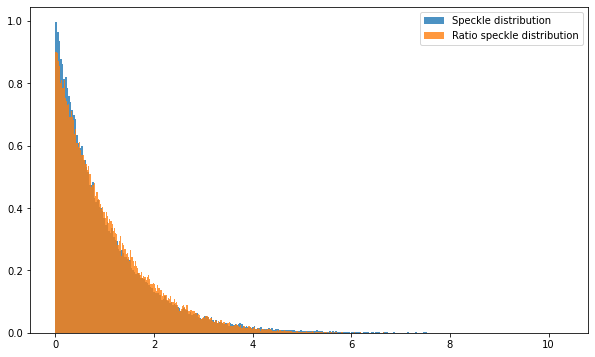

In [18]:
#visualisation de la distribution Gamma(1,1)
M = 10000
U = scipy.stats.gamma.rvs(a = 1, scale = 1,  size = (10,M))

#visualisation de la distribution du bruit de ratio
U_mean = np.mean(U, axis = 0)
R = U / U_mean[None,:]
R = R.reshape(-1)

U = U.reshape(-1)
print(U.shape)
print(R.shape)

plt.figure(figsize = (10,6))
plt.hist(U, bins = 'sqrt', label = 'Speckle distribution', density = 'True', alpha = 0.8)
plt.hist(R, bins = 'sqrt', label = 'Ratio speckle distribution', density = 'True', alpha = 0.8)
plt.legend()
plt.show()